In [1]:
import os
import re
import ast
import json
import torch
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
from tqdm import tqdm
from umap import UMAP
from torch.nn import CosineSimilarity
from scipy.stats import pointbiserialr
from datasets import load_dataset, load_from_disk
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModel

tqdm.pandas()

# Seaborn settings
sns.set_context("notebook")
sns.set_palette("colorblind")
sns.color_palette("pastel")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

# Matplotlib settings
# os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.rcParams.update({
#   "text.usetex": True,
#   "font.family": "serif",
#   "font.serif": "cm",
#   "font.size": 16,
# })


/home/hua2bv/miniconda3/envs/llm-tta/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Abstract & Intro

In [2]:
# sentiment_bert_delta = 56.91 - 52.05
# print(f"Sentiment BERT delta: {sentiment_bert_delta:.2f}")
# toxic_bert_delta = 60.75 - 53.90
# # toxic_bert_delta = 64.36 - 53.90
# print(f"Toxicity BERT delta: {toxic_bert_delta:.2f}")
# news_bert_delta = 89.75 - 88.57
# print(f"News BERT delta: {news_bert_delta:.2f}")

# mean_bert_delta = (sentiment_bert_delta + toxic_bert_delta + news_bert_delta) / 3
# print(f"Mean BERT delta: {mean_bert_delta:.2f}\n")

In [3]:
# sentiment_t5_delta = 59.83 - 57.99
# print(f"Sentiment T5 delta: {sentiment_t5_delta:.2f}")
# toxic_t5_delta = 63.89 - 58.81
# print(f"Toxicity T5 delta: {toxic_t5_delta:.2f}")
# news_t5_delta = 90.53 - 89.01
# print(f"News T5 delta: {news_t5_delta:.2f}")

# mean_t5_delta = (sentiment_t5_delta + toxic_t5_delta + news_t5_delta) / 3
# print(f"Mean T5 delta: {mean_t5_delta:.2f}\n")

In [4]:
# sentiment_falcon_delta = 44.20 - 47.16
# print(f"Sentiment Falcon delta: {sentiment_falcon_delta:.2f}")
# toxic_falcon_delta = 58.41 - 66.68
# print(f"Toxicity Falcon delta: {toxic_falcon_delta:.2f}")
# news_falcon_delta = 28.16 - 25.96
# print(f"News Falcon delta: {news_falcon_delta:.2f}")

# mean_falcon_delta = (sentiment_falcon_delta + toxic_falcon_delta + news_falcon_delta) / 3
# print(f"Mean Falcon delta: {mean_falcon_delta:.2f}\n")

In [5]:
# sentiment_augmentation_rate = 56.51
# print(f"Sentiment augmentation rate: {sentiment_augmentation_rate:.2f}")
# toxic_augmentation_rate = 66.46
# print(f"Toxicity augmentation rate: {toxic_augmentation_rate:.2f}")
# news_augmentation_rate = 3.76
# print(f"News augmentation rate: {news_augmentation_rate:.2f}")
# mean_augmentation_rate = (sentiment_augmentation_rate + toxic_augmentation_rate + news_augmentation_rate) / 3
# reduction = 100 - mean_augmentation_rate
# print(f"Mean augmentation rate: {reduction:.2f}")

In [6]:
# sentiment_translate_bert_delta = 52.60 - 52.05
# print(f"Sentiment BERT delta: {sentiment_translate_bert_delta:.2f}")
# toxic_translate_bert_delta = 61.65 - 53.90
# print(f"Toxicity BERT delta: {toxic_translate_bert_delta:.2f}")
# news_translate_bert_delta = 88.82 - 88.57
# print(f"News BERT delta: {news_translate_bert_delta:.2f}")

# mean_translate_bert_delta = (sentiment_translate_bert_delta + toxic_translate_bert_delta + news_translate_bert_delta) / 3
# print(f"Mean BERT delta: {mean_translate_bert_delta:.2f}\n")

In [7]:
# sentiment_insert_bert_delta = 51.92 - 52.05
# print(f"Sentiment BERT delta: {sentiment_insert_bert_delta:.2f}")
# toxic_insert_bert_delta = 53.10 - 53.90
# print(f"Toxicity BERT delta: {toxic_insert_bert_delta:.2f}")
# news_insert_bert_delta = 88.84 - 88.57
# print(f"News BERT delta: {news_insert_bert_delta:.2f}")

# mean_insert_bert_delta = (sentiment_insert_bert_delta + toxic_insert_bert_delta + news_insert_bert_delta) / 3
# print(f"Mean BERT delta: {mean_insert_bert_delta:.2f}\n")

In [8]:
# sentiment_sub_bert_delta = 51.78 - 52.05
# print(f"Sentiment BERT delta: {sentiment_sub_bert_delta:.2f}")
# toxic_sub_bert_delta = 53.37 - 53.90
# print(f"Toxicity BERT delta: {toxic_sub_bert_delta:.2f}")
# news_sub_bert_delta = 88.86 - 88.57
# print(f"News BERT delta: {news_sub_bert_delta:.2f}")

# mean_sub_bert_delta = (sentiment_sub_bert_delta + toxic_sub_bert_delta + news_sub_bert_delta) / 3
# print(f"Mean BERT delta: {mean_sub_bert_delta:.2f}\n")

In [9]:
# sentiment_id_bert_delta = 90.85 - 90.38
# print(f"Sentiment BERT delta: {sentiment_id_bert_delta:.2f}")
# toxic_id_bert_delta = 91.45 - 88.46
# print(f"Toxicity BERT delta: {toxic_id_bert_delta:.2f}")
# news_id_bert_delta = 93.53 - 94.43
# print(f"News BERT delta: {news_id_bert_delta:.2f}")

# mean_id_bert_delta = (sentiment_id_bert_delta + toxic_id_bert_delta + news_id_bert_delta) / 3
# print(f"Mean BERT delta: {mean_id_bert_delta:.2f}\n")

In [10]:
# set seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [11]:
# display full dataframes
pd.set_option("display.max_columns", None)

In [12]:
# plotting constants
TITLE_FONT_SIZE = 16
WSPACE = 0.3
FIGURE_HEIGHT = 3
LINE_WIDTH = 2
FIG_SIZE = 4
MARKER_SIZE = 8
X_LABEL_ROTATION = 20

In [13]:

inference_logs = load_from_disk("data/combined_dataset_multiseed")
list(inference_logs.keys())

['seed=3_BOSS_Sentiment_SST5_BERT_Insert',
 'seed=3_BOSS_Sentiment_SST5_BERT_Substitute',
 'seed=3_BOSS_Sentiment_SST5_BERT_Translate',
 'seed=3_BOSS_Sentiment_SST5_BERT_Paraphrase',
 'seed=3_BOSS_Sentiment_SST5_BERT_ICR',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Insert',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Substitute',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Translate',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Paraphrase',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT3000_ICR',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT6000_Insert',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT6000_Substitute',
 'seed=3_BOSS_Sentiment_Ablate_Data_SST5_BERT6000

In [21]:
def parse_task_name(split_name):
    return "Sentiment" if "Sentiment" in split_name else "Toxicity" if "Toxicity" in split_name else "News"

def parse_distribution(split_name):
    return split_name.split("_")[-3]

def parse_model(split_name):
    return split_name.split("_")[-2]

def parse_tta_method(split_name):
    return split_name.split("_")[-1]

def parse_seed(split_name):
    return int(split_name.split("_")[0].split("seed=")[-1])

def format_split_name(split_name):
    return split_name[7:]


formatted_method_names = {
    "Insert": "Insert",
    "Substitute": "Substitute",
    "Translate": "Translate",
    "Paraphrase": "LLM-TTA: Paraphrase",
    "ICR": "LLM-TTA: ICR",
}
    

In [15]:
multiseed_inference_logs = {}
for split_name in tqdm(inference_logs):
    seed = parse_seed(split_name)
    if seed not in multiseed_inference_logs:
        multiseed_inference_logs[seed] = {}
    
    formatted_split_name = format_split_name(split_name)
    multiseed_inference_logs[seed][formatted_split_name] = inference_logs[split_name]

multiseed_inference_logs

100%|██████████| 1095/1095 [00:00<00:00, 439793.44it/s]


{3: {'BOSS_Sentiment_SST5_BERT_Insert': Dataset({
      features: ['outcome', 'original_text', 'augmentations', 'generations', 'original_predicted_class', 'tta_predicted_class', 'label', 'tta_inference_latency', 'original_prediction_entropy', 'tta_prediction_entropy', 'prediction_entropy_decreased', 'prediction_entropy_decrease', 'tta_mean_class_probs', 'tta_all_class_probs', 'tta_all_class_entropy'],
      num_rows: 1068
  }),
  'BOSS_Sentiment_SST5_BERT_Substitute': Dataset({
      features: ['outcome', 'original_text', 'augmentations', 'generations', 'original_predicted_class', 'tta_predicted_class', 'label', 'tta_inference_latency', 'original_prediction_entropy', 'tta_prediction_entropy', 'prediction_entropy_decreased', 'prediction_entropy_decrease', 'tta_mean_class_probs', 'tta_all_class_probs', 'tta_all_class_entropy'],
      num_rows: 1068
  }),
  'BOSS_Sentiment_SST5_BERT_Translate': Dataset({
      features: ['outcome', 'original_text', 'augmentations', 'generations', 'origina

## No TTA Baselines

In [23]:
no_tta_accuracies = {}
for seed in multiseed_inference_logs:
    no_tta_accuracies[seed] = {}
    for split_name in tqdm(multiseed_inference_logs[seed], desc=f"Seed = {seed}"):
        split_frame = multiseed_inference_logs[seed][split_name].to_pandas()
        split_no_tta_accuracy = classification_report(split_frame["label"], split_frame["original_predicted_class"], output_dict=True, zero_division=0.0)["accuracy"]
        no_tta_accuracies[seed][split_name] = split_no_tta_accuracy

no_tta_accuracies

Seed = 58: 100%|██████████| 265/265 [00:16<00:00, 16.12it/s]


{3: {'BOSS_Sentiment_SST5_BERT_Insert': 0.6844569288389513,
  'BOSS_Sentiment_SST5_BERT_Substitute': 0.6844569288389513,
  'BOSS_Sentiment_SST5_BERT_Translate': 0.6850467289719626,
  'BOSS_Sentiment_SST5_BERT_Paraphrase': 0.6844569288389513,
  'BOSS_Sentiment_SST5_BERT_ICR': 0.6844569288389513,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR': 0.6825842696629213,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Insert': 0.6779026217228464,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Substitute': 0.6779026217228464,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Translate': 0.6779026217228464,
  'BOSS_Sentiment_Ablate_Data_SST5_BERT3000_Paraphrase': 0.6779026217228464,
  'BOSS_Sentiment_Ablate_Dat

## Analyze Main Results

In [ ]:
multiseed_split_data = {}
for seed in multiseed_inference_logs:
    main_results_bert_splits = [split for split in multiseed_inference_logs[seed].keys() if "Ablate" not in split]
    datasets = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
    split_data = {}

    for task_name in datasets:
        if task_name not in split_data:
            split_data[task_name] = {}

        for split in tqdm(main_results_bert_splits, desc=f"Processing splits for {task_name} Seed={seed}"):
            if task_name in split:
                distribution = split.split("_")[-3]
                model = split.split("_")[-2]
                tta_method = split.split("_")[-1]
                baseline_accuracy = classification_report(multiseed_inference_logs[seed][split]["label"], multiseed_inference_logs[seed][split]["original_predicted_class"], output_dict=True, zero_division=0.0)["accuracy"]
                tta_accuracy = classification_report(multiseed_inference_logs[seed][split]["label"], multiseed_inference_logs[seed][split]["tta_predicted_class"], output_dict=True, zero_division=0.0)["accuracy"]
                accuracy_delta = tta_accuracy - baseline_accuracy

                if model not in split_data[task_name]:
                    split_data[task_name][model] = {}

                if tta_method not in split_data[task_name][model]:
                    split_data[task_name][model][tta_method] = {}

                split_data[task_name][model][tta_method][distribution] = {
                    "distribution": distribution,
                    "model": model,
                    "tta_method": tta_method,
                    "baseline_accuracy": baseline_accuracy,
                    "tta_accuracy": tta_accuracy,
                    "accuracy_delta": accuracy_delta
                }

        # get the Accuracy Gain for each method excluding ID
        for model_name in split_data[task_name]:
            for tta_method in split_data[task_name][model_name]:
                accuracies = []
                accuracy_deltas = []
                baseline_accuracies = []
                for distribution in split_data[task_name][model_name][tta_method]:
                    if distribution == "ID":
                        continue

                    current_tta_result = split_data[task_name][model_name][tta_method][distribution]
                    accuracies.append(current_tta_result["tta_accuracy"])
                    accuracy_deltas.append(current_tta_result["accuracy_delta"])
                    baseline_accuracies.append(current_tta_result["baseline_accuracy"])

                split_data[task_name][model_name][tta_method]["mean_accuracy"] = np.mean(accuracies)
                split_data[task_name][model_name][tta_method]["mean_accuracy_delta"] = np.mean(accuracy_deltas)
                split_data[task_name][model_name][tta_method]["mean_baseline_accuracy"] = np.mean(baseline_accuracies)

    # print(json.dumps(split_data, indent=4))
    multiseed_split_data[seed] = split_data

print(json.dumps(multiseed_split_data, indent=4))

In [ ]:
multiseed_detailed_results = {}
for seed in multiseed_split_data:
    multiseed_detailed_results[seed] = {}
    detailed_results_records = []
    for task_name in multiseed_split_data[seed]:
        for model_name in multiseed_split_data[seed][task_name]:
            for tta_method in multiseed_split_data[seed][task_name][model_name]:
                for dist in [dist for dist in multiseed_split_data[seed][task_name][model_name][tta_method] if not dist.startswith("mean")]:

                    perf_record = multiseed_split_data[seed][task_name][model_name][tta_method][dist]
                    detailed_results_records.append({
                        "task": task_name,
                        "model": model_name,
                        "tta_method": tta_method,
                        "distribution": dist,
                        # "baseline_accuracy": perf_record["baseline_accuracy"] * 100,
                        # "tta_accuracy": perf_record["tta_accuracy"] * 100,
                        # "accuracy_delta": round(perf_record["accuracy_delta"] * 100, 2),
                        "mean_accuracy": perf_record["tta_accuracy"] * 100,
                    })
                    detailed_results_records.append({
                        "task": task_name,
                        "model": model_name,
                        "tta_method": "None",
                        "distribution": dist,
                        "mean_accuracy": perf_record["baseline_accuracy"] * 100,
                    })


    print(f"Seed: {seed}")

    detailed_results_frame = pd.DataFrame(detailed_results_records)
    for task_name in multiseed_split_data[seed]:
        task_frame = detailed_results_frame[detailed_results_frame["task"] == task_name]
        display(task_frame.groupby(["task", "model", "distribution", "tta_method", ]).mean().round(2).T)

    full_sweep_results = detailed_results_frame.groupby(["task", "model", "distribution", "tta_method", ]).mean().round(2)
    full_sweep_results.to_csv(f"data/seed={seed}_detailed_results.csv")
    multiseed_detailed_results[seed] = full_sweep_results

print("Across Seeds")
multiseed_detailed_results

In [ ]:
# create dataframe where there is a column for dataset, model, id_accuracy_delta, and mean_accuracy_delta
records = []
num_seeds = len(multiseed_detailed_results.keys())
print(f"Aggregating results across {num_seeds} seeds")

for seed in multiseed_detailed_results:
    for task_name in tqdm(multiseed_split_data[seed]):
        for model_name in multiseed_split_data[seed][task_name]:
            for tta_method in multiseed_split_data[seed][task_name][model_name]:
                current_tta_result = multiseed_split_data[seed][task_name][model_name][tta_method]
                records.append({
                    "dataset": task_name,
                    "model": model_name,
                    "tta_method": tta_method,
                    "ood_mean_accuracy": current_tta_result["mean_accuracy"] * 100,
                })
                records.append({
                    "dataset": task_name,
                    "model": model_name,
                    "tta_method": "None",
                    "ood_mean_accuracy": current_tta_result["mean_baseline_accuracy"] * 100,
                })

main_results_frame = pd.DataFrame(records)
for model in split_data[task_name]:
    display(model)
    display(main_results_frame[main_results_frame["model"] == model].drop(columns="model").groupby(["dataset", "tta_method"]).agg(['mean', 'std']).round(2).T)

aggregated_main_results = main_results_frame.groupby(["dataset", "model", "tta_method"]).agg(['mean', 'std']).round(2).T

### Get Max STD

In [ ]:
# aggregated_main_results.groupby(["dataset", "tta_method"]).drop(columns="model").agg(["std"]).groupby("tta_method").mean().round(4).T

In [ ]:
# aggregated_main_results.groupby(["dataset", "model", "tta_method"]).agg(["std"]).max().round(2).T

### Build Main OOD Results LaTEX Table

In [ ]:
aggregated_main_results["AgNewsTweets"]["BERT"]

In [ ]:

task_order = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
model_order = ["BERT", "T5", "Falcon"]
tta_order = ["None", "Insert", "Substitute", "Translate", "Paraphrase", "ICR"]
citation_map = {
    "None": "None",
    "Insert": "Insert \citep{Lu2022ImprovedTC}",
    "Substitute": "Substitute \citep{Lu2022ImprovedTC}",
    "Translate": "Translate \citep{Sennrich2015ImprovingNM}",
    "Paraphrase": "LLM--TTA: Paraphrase",
    "ICR": "LLM--TTA: ICR",
}

table_latex_lines = []
for tta_method in tta_order:
    row_entries = [citation_map[tta_method]]
    for task in task_order:
        for model in model_order:
            mean_accuracy = aggregated_main_results[task][model][tta_method]["ood_mean_accuracy"]["mean"]
            formatted_acc  = f"{mean_accuracy:.2f}\\%"
            best_acc = max([aggregated_main_results[task][model][method_name]["ood_mean_accuracy"]["mean"] for method_name in tta_order])
            is_best_method = mean_accuracy == best_acc
            if is_best_method:
                formatted_acc = "\\textbf{" + formatted_acc + "}"
            
            row_entries.append(formatted_acc)

    row_latex = "    " + " & ".join(row_entries) + " \\\\"
    print(row_latex)

    table_latex_lines.append(row_latex)
    if tta_method in ["None", "Translate"]:
        dash_line = "    " + "\cdashlinelr{1-10}"
        table_latex_lines.append(dash_line)
        print(dash_line)
            

In [ ]:

task_order = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
model_order = ["BERT", "T5", "Falcon"]
tta_order = ["None", "Insert", "Substitute", "Translate", "Paraphrase", "ICR"]
citation_map = {
    "None": "None",
    "Insert": "Insert \citep{Lu2022ImprovedTC}",
    "Substitute": "Substitute \citep{Lu2022ImprovedTC}",
    "Translate": "Translate \citep{Sennrich2015ImprovingNM}",
    "Paraphrase": "LLM--TTA: Paraphrase",
    "ICR": "LLM--TTA: ICR",
}

table_latex_lines = []
for tta_method in tta_order:
    row_entries = [citation_map[tta_method]]
    for task in task_order:
        for model in model_order:
            mean_accuracy = aggregated_main_results[task][model][tta_method]["ood_mean_accuracy"]["mean"]
            formatted_acc  = f"{mean_accuracy:.2f}\\%"
            best_acc = max([aggregated_main_results[task][model][method_name]["ood_mean_accuracy"]["mean"] for method_name in tta_order])
            is_best_method = mean_accuracy == best_acc
            if is_best_method:
                formatted_acc = "\\textbf{" + formatted_acc + "}"
            
            row_entries.append(formatted_acc)

    row_latex = "    " + " & ".join(row_entries) + " \\\\"
    print(row_latex)

    table_latex_lines.append(row_latex)
    if tta_method in ["None", "Translate"]:
        dash_line = "    " + "\cdashlinelr{1-10}"
        table_latex_lines.append(dash_line)
        print(dash_line)
            

## Dataset Stats

In [ ]:
split_label_value_counts = {}

for split_name in multiseed_inference_logs[3]:
    if "BERT" not in split_name:
        continue

    set_name = split_name.split("_BERT")[0]
    if set_name in split_label_value_counts:
        continue

    split_frame = multiseed_inference_logs[3][split_name].to_pandas()
    label_counts = split_frame["label"].value_counts().to_dict()
    label_counts[-1] = len(split_frame)
    label_counts = {k: label_counts[k] for k in sorted(label_counts)}
    split_label_value_counts[set_name] = label_counts

display(pd.DataFrame(split_label_value_counts))

# Analyze Across Dataset Sizes

In [ ]:
data_ablation_results = []
for seed in multiseed_inference_logs:
    for split_name in tqdm(multiseed_inference_logs[seed], desc=f"Seed = {seed}"):
        if "Ablate_Data" not in split_name:
            continue

        task_name = parse_task_name(split_name)
        data_count = int(split_name.split("_")[-2].replace("BERT", ""))
        tta_method = split_name.split("_")[-1]
        shift_name = split_name.split("_")[-3]
        baseline_accuracy = classification_report(multiseed_inference_logs[seed][split_name]["label"], multiseed_inference_logs[seed][split_name]["original_predicted_class"], output_dict=True)["accuracy"]
        tta_accuracy = classification_report(multiseed_inference_logs[seed][split_name]["label"], multiseed_inference_logs[seed][split_name]["tta_predicted_class"], output_dict=True)["accuracy"]
        data_ablation_results.append({
            "task": task_name,
            "shift": shift_name,
            "seed": seed,
            "data_count": data_count,
            "tta_method": formatted_method_names[tta_method],
            "baseline_accuracy": baseline_accuracy,
            "tta_accuracy": tta_accuracy,
            "acc_gain": tta_accuracy - baseline_accuracy
        })

data_ablation_results_frame = pd.DataFrame(data_ablation_results)
data_ablation_results_frame

In [ ]:
data_ablation_results_frame[data_ablation_results_frame["task"] == "Toxicity"]

In [ ]:
toxic_frame = data_ablation_results_frame[data_ablation_results_frame["task"] == "Toxicity"][["task", "seed", "data_count", "tta_method", "acc_gain"]]
toxic_frame[toxic_frame["seed"] == 46]

In [ ]:
# sort by seed
data_ablation_results_frame[data_ablation_results_frame["task"] == "Toxicity"].value_counts(["seed", "shift", "data_count", "tta_method"]).sort_index().to_csv("check_tox_ablations")

In [ ]:
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][3][24000])
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][17][24000])
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][46][24000])
display(toxic_frame.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain").T["Toxicity"][58][24000])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for i, task_name in enumerate(["Sentiment", "Toxicity", "News"]):
    # df = pd.concat([pd.DataFrame(pandas_form[task_name][data_count]) for data_count in pandas_form[task_name]])
    data_ablation_plotting_df = data_ablation_results_frame[data_ablation_results_frame["task"] == task_name]
    data_ablation_plotting_df = data_ablation_plotting_df[data_ablation_plotting_df["seed"] != 58]
    agg_data_ablation_plotting_df = data_ablation_plotting_df.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain")
    sns.lineplot(
        data=agg_data_ablation_plotting_df,
        x="data_count",
        y="acc_gain",
        hue="tta_method",
        ax=axes[i],
        linewidth=LINE_WIDTH,
        markersize=MARKER_SIZE,
        style="tta_method",
        dashes=False,
        markers=True,
        errorbar="sd",
    )

    # set x label to Training Set Size
    axes[i].set_xlabel("Training Set Size")

    # set y label to Mean Absolute Accuracy Delta
    axes[i].set_ylabel("Accuracy Gain")

    # make the y axis percents that go to the hundreds place
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize the y axis between the min and max of df
    axes[i].set_ylim(data_ablation_plotting_df["acc_gain"].min() - 0.005, data_ablation_plotting_df["acc_gain"].max() + 0.005)

    axes[i].set_title(task_name, fontsize=TITLE_FONT_SIZE)

    # se legend to the bottom left
    axes[i].legend(loc="lower right")

    # make x axis log
    axes[i].set_xscale("log")

    # show more x axis ticks at 10%, 20%, 40%, 80%
    x_ticks = sorted(data_ablation_plotting_df["data_count"].unique().tolist())
    tick_labels = [str(int(x)) for x in x_ticks]
    axes[i].set_xticks(x_ticks, tick_labels, minor=False)

    # remove extra ticks not in x_ticks
    axes[i].set_xticks(x_ticks, minor=True)

    # rotate x axis labels
    axes[i].tick_params(axis='x', rotation=X_LABEL_ROTATION)

    # if news add addiitonal precision to the y axis
    # if task_name == "AgNewsTweets":
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")

    # remove leegnd in not middle plot
    if i != 1:
        axes[i].get_legend().remove()
    else:
        # center below plot with no frame
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=5, frameon=False, fontsize=14)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)

if not os.path.exists("figures/"):
    os.makedirs("figures/")

fig.savefig("figures/method_analysis_data_ablation.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_data_ablation.png", bbox_inches="tight")

## Aggregation Ablation Study

In [26]:
def aggregate_predictions(predictions, num_predictions, use_test_input):
    try:
        ablation_preds = predictions[:num_predictions]
        if use_test_input:
            ablation_preds = ablation_preds.tolist() + [predictions[-1]]
        
        mean_distribution = np.mean(ablation_preds, axis=0) if len(ablation_preds) > 1 else ablation_preds[0]
        predicted_class = np.argmax(mean_distribution)
        return predicted_class
    except:
        return -1

perf_records = []
for seed in multiseed_inference_logs:
    agg_ablation_splits = [name for name in multiseed_inference_logs[seed] if "Ablate" not in name and "BERT" in name]
    for split_name in tqdm(agg_ablation_splits, desc=f"Seed = {seed}"):
        dataset = parse_task_name(split_name)
        distribution = parse_distribution(split_name)
        model = parse_model(split_name)
        method = parse_tta_method(split_name)

        current_frame = multiseed_inference_logs[seed][split_name].to_pandas()
        for use_source in [False, True]:
            for num_augmentations in range(1, 5): #TODO: set to 5
                judgments = current_frame["tta_all_class_probs"].apply(lambda x: aggregate_predictions(x, num_augmentations, use_source))
                accuracy = classification_report(current_frame["label"], judgments, output_dict=True, zero_division=0.0)["accuracy"]
                perf_records.append({
                    "dataset": dataset,
                    "seed": seed,
                    "distribution": distribution,
                    "model": model,
                    "method": formatted_method_names[method],
                    "use_source": use_source,
                    "num_augmentations": num_augmentations,
                    "accuracy": accuracy,
                    "delta": accuracy - no_tta_accuracies[seed][split_name],
                })

aggregation_ablation_frame = pd.DataFrame(perf_records)
aggregation_ablation_frame

Seed = f58: 100%|██████████| 35/35 [00:55<00:00,  1.59s/it]


,dataset,seed,distribution,model,method,use_source,num_augmentations,accuracy,delta
0,Sentiment,3,SST5,BERT,Insert,False,1,0.639513,-0.044944
1,Sentiment,3,SST5,BERT,Insert,False,2,0.648876,-0.035581
2,Sentiment,3,SST5,BERT,Insert,False,3,0.654494,-0.029963
3,Sentiment,3,SST5,BERT,Insert,False,4,0.655431,-0.029026
4,Sentiment,3,SST5,BERT,Insert,True,1,0.667603,-0.016854
...,...,...,...,...,...,...,...,...,...
1115,News,58,Tweets,BERT,LLM-TTA: ICR,False,4,0.891607,0.005919
1116,News,58,Tweets,BERT,LLM-TTA: ICR,True,1,0.895685,0.009997
1117,News,58,Tweets,BERT,LLM-TTA: ICR,True,2,0.895948,0.010260
1118,News,58,Tweets,BERT,LLM-TTA: ICR,True,3,0.896080,0.010392


In [81]:
aggregation_ablation_frame[(aggregation_ablation_frame["distribution"] == "SST5") & (aggregation_ablation_frame["num_augmentations"] == 4) & (aggregation_ablation_frame["method"] == "LLM-TTA: ICR") & (aggregation_ablation_frame["use_source"] == True)]

,dataset,seed,distribution,model,method,use_source,num_augmentations,accuracy,delta
39,Sentiment,3,SST5,BERT,LLM-TTA: ICR,True,4,0.729401,0.044944
319,Sentiment,17,SST5,BERT,LLM-TTA: ICR,True,4,0.724719,0.040262
599,Sentiment,46,SST5,BERT,LLM-TTA: ICR,True,4,0.724719,0.040262
879,Sentiment,58,SST5,BERT,LLM-TTA: ICR,True,4,0.731273,0.046816


In [76]:
test_frame = aggregation_ablation_frame.copy()[["dataset", "model", "method", "num_augmentations", "use_source", "delta"]]
test_frame = test_frame[test_frame["use_source"] == True]
test_frame.drop(columns="use_source", inplace=True)
# test_frame = test_frame.groupby(["dataset", "model", "method", "num_augmentations"]).mean("acc_gain")
test_frame = test_frame.groupby(["dataset", "model", "method", "num_augmentations"]).agg(["mean", "std"])
test_frame

delta          
                                                           mean       std
dataset   model method              num_augmentations                    
News      BERT  Insert              1                  0.001611  0.001524
                                    2                  0.001381  0.000509
                                    3                  0.002565  0.001066
                                    4                  0.002236  0.000635
                LLM-TTA: ICR        1                  0.009800  0.000863
                                    2                  0.009077  0.001320
                                    3                  0.010096  0.000682
                                    4                  0.009109  0.000572
                LLM-TTA: Paraphrase 1                  0.003124  0.001505
                                    2                 -0.001348  0.000448
                                    3                  0.000855  0.000684
                                    4                 -0.001250  0.000348
                Substitute          1                 -0.002401  0.000821
                                    2                 -0.003190  0.000699
                                    3                  0.000066  0.000509
                                    4                 -0.000460  0.000915
                Translate           1                  0.002368  0.000000
                                    2                 -0.005393  0.000000
                                    3                 -0.003815  0.000000
                                    4                 -0.004999  0.000000
Sentiment BERT  Insert              1                 -0.005928  0.004487
                                    2                 -0.007059  0.002455
                                    3                 -0.007852  0.005494
                                    4                 -0.007751  0.006246
                LLM-TTA: ICR        1                  0.036379  0.006284
                                    2                  0.046326  0.010099
                                    3                  0.048955  0.010364
                                    4                  0.050681  0.011660
                LLM-TTA: Paraphrase 1                  0.022530  0.003182
                                    2                  0.029464  0.004457
                                    3                  0.032795  0.003091
                                    4                  0.034956  0.003264
                Substitute          1                 -0.014395  0.010542
                                    2                 -0.015199  0.010923
                                    3                 -0.017724  0.013074
                                    4                 -0.014818  0.010002
                Translate           1                  0.000207  0.007410
                                    2                  0.004699  0.003247
                                    3                  0.002993  0.008723
                                    4                  0.001308  0.006372
Toxicity  BERT  Insert              1                 -0.003097  0.008687
                                    2                 -0.005633  0.014381
                                    3                 -0.006771  0.016049
                                    4                 -0.009043  0.019588
                LLM-TTA: ICR        1                  0.051229  0.068600
                                    2                  0.068352  0.110448
                                    3                  0.074897  0.116189
                                    4                  0.076700  0.122780
                LLM-TTA: Paraphrase 1                  0.078300  0.111497
                                    2                  0.105783  0.161416
                                    3                  0.112722  0.170613
                                    4                  0.11576

In [96]:
current_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == task_name]
current_frame.groupby(["dataset", "seed", "method"]).mean("delta")

use_source  num_augmentations  accuracy  \
dataset   seed method                                                         
Sentiment 3    Insert                      0.5                2.5  0.503085   
               LLM-TTA: ICR                0.5                2.5  0.565705   
               LLM-TTA: Paraphrase         0.5                2.5  0.554936   
               Substitute                  0.5                2.5  0.492742   
               Translate                   0.5                2.5  0.522771   
          17   Insert                      0.5                2.5  0.509035   
               LLM-TTA: ICR                0.5                2.5  0.566783   
               LLM-TTA: Paraphrase         0.5                2.5  0.552243   
               Substitute                  0.5                2.5  0.487239   
               Translate                   0.5                2.5  0.522771   
          46   Insert                      0.5                2.5  0.508975   
               LLM-TTA: ICR                0.5                2.5  0.568101   
               LLM-TTA: Paraphrase         0.5                2.5  0.550840   
               Substitute                  0.5                2.5  0.488530   
               Translate                   0.5                2.5  0.522771   
          58   Insert                      0.5                2.5  0.507615   
               LLM-TTA: ICR                0.5                2.5  0.565935   
               LLM-TTA: Paraphrase         0.5                2.5  0.553852   
               Substitute                  0.5                2.5  0.491847   
               Translate                   0.5                2.5  0.522771   

                                       delta  
dataset   seed method                         
Sentiment 3    Insert              -0.017349  
               LLM-TTA: ICR         0.045271  
               LLM-TTA: Paraphrase  0.034502  
               Substitute          -0.027692  
               Translate            0.002140  
          17   Insert              -0.011399  
               LLM-TTA: ICR         0.046349  
               LLM-TTA: Paraphrase  0.031809  
               Substitute          -0.033195  
               Translate            0.002140  
          46   Insert              -0.011459  
               LLM-TTA: ICR         0.047667  
               LLM-TTA: Paraphrase  0.030406  
               Substitute          -0.031905  
               Translate            0.002140  
          58   Insert              -0.012819  
               LLM-TTA: ICR         0.045501  
               LLM-TTA: Paraphrase  0.033418  
               Substitute          -0.028588  
               Translate            0.002140

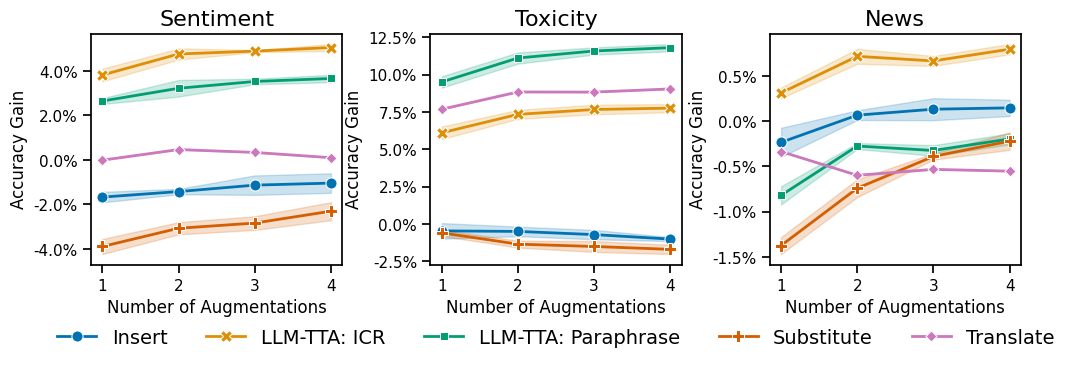

In [102]:
# select where distribution != ID
aggregation_ablation_frame = aggregation_ablation_frame[aggregation_ablation_frame["distribution"] != "ID"]

# set method to TTA if not Paraphrase or ICR and LLM-TTA if Paraphrase or ICR
# aggregation_ablation_frame["method"] = aggregation_ablation_frame["method"].apply(lambda x: "TTA" if x not in ["Paraphrase", "ICR"] else "LLM-TTA")

# for tta_method in ["Conventional Augmentation", "Paraphrase", "ICR"]:
# aggregation_ablation_frame["method"] = aggregation_ablation_frame["method"].apply(lambda x: "ICR" if "ICR" in x else "Paraphrase" if "Paraphrase" in x else "Conventional Augmentation")

# create three figures, one for Sentiment, Toxicity, and News

fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for index, task_name in enumerate(["Sentiment", "Toxicity", "News"]):
    # get the current task frame
    current_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == task_name]
    # current_frame = current_frame[["dataset", "model", "method", "num_augmentations", "use_source", "delta"]]
    current_frame = current_frame[current_frame["use_source"] == True]
    current_frame = current_frame.drop(columns="use_source")
    current_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == task_name]
    current_frame = current_frame.groupby(["dataset", "seed", "num_augmentations", "method"]).mean("delta")
    # data_ablation_plotting_df.groupby(["task", "seed", "data_count", "tta_method"]).mean("acc_gain")
    # cross_seed_frame = current_frame.groupby(["dataset", "model", "method", "num_augmentations"]).mean("delta")

    # plot the current task frame
    sns.lineplot(
        data=current_frame,
        x="num_augmentations",
        y="delta",
        hue="method",
        style="method",
        ax=axes[index],
        linewidth=LINE_WIDTH,
        dashes=False,
        markers=True,
        markersize=MARKER_SIZE,
        errorbar="sd",
    )

    # set x label to Number of Augmentations
    axes[index].set_xlabel("Number of Augmentations")

    # set y label to Accuracy
    axes[index].set_ylabel("Accuracy Gain")

    # make the y axis percents that go to the hundreds place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # set title to Sentiment, Toxicity, or News
    axes[index].set_title(task_name, fontsize=TITLE_FONT_SIZE)

    # se legend to the bottom left
    axes[index].legend(loc="lower right")

    # remove leegnd in not middle plot
    if index != 1:
        axes[index].get_legend().remove()
    else:
        # center below plot with no frame
        axes[index].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=5, frameon=False, fontsize=14)
    
    # have y ticks to the tenths place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)

fig.savefig("figures/method_analysis_aggrgeation_ablation.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_aggrgeation_ablation.png", bbox_inches="tight")

## Does TTA Affect Some Classes More Than Others?

In [ ]:
ood_sentiment_icr_data = None
ood_toxicity_icr_data = None
ood_tweets_icr_data = None

for seed in multiseed_inference_logs:
    for split_name in tqdm(multiseed_inference_logs[seed]):
        if "ICR" not in split_name and "ID" in split_name or "BERT" not in split_name or "Ablate" in split_name:
            continue

        current_frame = multiseed_inference_logs[seed][split_name].to_pandas()
        current_frame["seed"] = seed
        current_frame["dataset"] = parse_distribution(split_name)

        if "Sentiment" in split_name:
            if ood_sentiment_icr_data is None:
                ood_sentiment_icr_data = current_frame
            else:
                ood_sentiment_icr_data = pd.concat([ood_sentiment_icr_data, current_frame])

        if "Toxicity" in split_name:
            if ood_toxicity_icr_data is None:
                ood_toxicity_icr_data = current_frame
            else:
                ood_toxicity_icr_data = pd.concat([ood_toxicity_icr_data, current_frame])

        if "Tweets" in split_name:
            if ood_tweets_icr_data is None:
                ood_tweets_icr_data = current_frame
            else:
                ood_tweets_icr_data = pd.concat([ood_tweets_icr_data, current_frame])


display(ood_sentiment_icr_data.value_counts("dataset"))
display(ood_toxicity_icr_data.value_counts("dataset"))
display(ood_tweets_icr_data.value_counts("dataset"))
assert len(ood_sentiment_icr_data.value_counts("dataset")) == 3
assert len(ood_toxicity_icr_data.value_counts("dataset")) == 3
assert len(ood_tweets_icr_data.value_counts("dataset")) == 1

In [ ]:
# don't crop the display frame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

aggregation_ablation_frame = pd.DataFrame(perf_records)
for dataset in ["Sentiment", "Toxicity", "News"]:
    dataset_frame = aggregation_ablation_frame[aggregation_ablation_frame["dataset"] == dataset]
    dataset_frame["distribution"] = dataset_frame["distribution"].apply(lambda x: "ID" if "ID" in x else "OOD")
    display(dataset_frame.groupby(["dataset", "distribution", "model", "method", "use_source", "num_augmentations"]).mean().T)

In [ ]:
# for each dataset, get the percent of examples that are unchanged vs new
sentiment_outcomes = ood_sentiment_icr_data["outcome"].apply(lambda x: "Correction" if x == "New Correct" else "Corruption" if x == "New Mistake" else x)
sentiment_percents = sentiment_outcomes.value_counts(normalize=True)
new_sentiment_percents = 100 * sentiment_percents[sentiment_percents.index == "Correction"].values[0] + sentiment_percents[sentiment_percents.index == "Corruption"].values[0]
print(f"Sentiment: {new_sentiment_percents:.2f}% of examples are new predictions")

toxicity_outcomes = ood_toxicity_icr_data["outcome"].apply(lambda x: "Correction" if x == "New Correct" else "Corruption" if x == "New Mistake" else x)
toxicity_percents = toxicity_outcomes.value_counts(normalize=True)
new_toxicity_percents = 100 * toxicity_percents[toxicity_percents.index == "Correction"].values[0] + toxicity_percents[toxicity_percents.index == "Corruption"].values[0]
print(f"Toxicity: {new_toxicity_percents:.2f}% of examples are new predictions")

agt_outcomes = ood_tweets_icr_data["outcome"].apply(lambda x: "Correction" if x == "New Correct" else "Corruption" if x == "New Mistake" else x)
agt_percents = agt_outcomes.value_counts(normalize=True)
new_agt_percents = 100 * agt_percents[agt_percents.index == "Correction"].values[0] + agt_percents[agt_percents.index == "Corruption"].values[0]
print(f"AGT: {new_agt_percents:.2f}% of examples are new predictions")

In [ ]:
sentiment_icr_outcome_percents = ood_sentiment_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
sentiment_icr_outcome_percents = sentiment_icr_outcome_percents[sentiment_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Sentiment ICR")
display(sentiment_icr_outcome_percents)

toxicity_icr_outcome_percents = ood_toxicity_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
toxicity_icr_outcome_percents = toxicity_icr_outcome_percents[toxicity_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Toxicity ICR")
display(toxicity_icr_outcome_percents)

tweets_icr_outcome_percents = ood_tweets_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
tweets_icr_outcome_percents = tweets_icr_outcome_percents[tweets_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Tweets ICR")
display(tweets_icr_outcome_percents)

In [ ]:
plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))

sentiment_labels = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}
sns.barplot(ax=axes[0], 
            x=sentiment_icr_outcome_percents.index.get_level_values("label").map(sentiment_labels), 
            y=sentiment_icr_outcome_percents.values,
            hue=sentiment_icr_outcome_percents.index.get_level_values("outcome"),
)

toxicity_labels = {
    0: "Non-Toxic",
    1: "Toxic",
}
sns.barplot(ax=axes[1],
            x=toxicity_icr_outcome_percents.index.get_level_values("label").map(toxicity_labels),
            y=toxicity_icr_outcome_percents.values,
            hue=toxicity_icr_outcome_percents.index.get_level_values("outcome"),
)

agt_labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
sns.barplot(ax=axes[2],
            x=tweets_icr_outcome_percents.index.get_level_values("label").map(agt_labels),
            y=tweets_icr_outcome_percents.values,
            hue=tweets_icr_outcome_percents.index.get_level_values("outcome"),
)

for i in range(3):
    # make y axis percents
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize between 0 and 0.1
    # axes[i].set_ylim(0, 0.09)

    # set y label to percent of overall outcomes
    axes[i].set_ylabel("Percent of Outcomes")

    # remove x label
    axes[i].set_xlabel("")

    # make the y axis percents that go to the hundreds place
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.1%}")

    if i == 2:
        # rotate the x labels
        axes[i].tick_params(axis="x", rotation=X_LABEL_ROTATION)

    # have fewer ticks on the y axis
    axes[i].locator_params(axis="y", nbins=5)

    # set titles
    title_text = {
        0: "Sentiment",
        1: "Toxicity",
        2: "News",
    }
    axes[i].set_title(title_text[i], fontsize=TITLE_FONT_SIZE)

    # have a single legend which is centered below the plot
    if i == 1:
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=False, fontsize=14)
    else:
        axes[i].get_legend().remove()

# add more horizental spacing for y labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)
fig.savefig("figures/method_analysis_class_analysis.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_class_analysis.png", bbox_inches="tight")
fig.show()

# Selective Augmentation

In [ ]:
# three figures on single line
fig, axes = plt.subplots(1, 2, figsize=(3 * FIG_SIZE, FIG_SIZE))
plottng_datas = [("Sentiment", ood_sentiment_icr_data), ("Toxicity", ood_toxicity_icr_data), ("News", ood_tweets_icr_data)]
change_int_mapping = {
    "Unchanged": 0,
    "New": 1,
}
outcome_int_mapping = {
    "Unchanged Correct": 0,
    "Unfixed Mistake": 1,
    "New Correct": 2,
    "New Mistake": 3,
}

change_correlations = {}
change_p_values = []
outcome_correlations = []
outcome_p_values = {}
for index, (title, icr_frame) in enumerate(plottng_datas):
    icr_frame["max_softmax"] = icr_frame["tta_mean_class_probs"].apply(lambda p: max(p))
    plotting_frame = icr_frame[["max_softmax", "original_prediction_entropy", "tta_prediction_entropy", "outcome"]].sort_values("outcome")
    plotting_frame["Change"] = plotting_frame["outcome"].apply(lambda x: 0 if x == "Unchanged Correct" or x == "Unfixed Mistake" else 1)

    correlation_metric = "original_prediction_entropy"
    pbc = pointbiserialr(plotting_frame[correlation_metric], plotting_frame["Change"])
    # change_correlations.append([pbc[0]])
    change_correlations[title] = pbc[0]
    change_p_values.append([pbc[1]])

    set_outcome_correlations = []
    for outcome in outcome_int_mapping:
        one_hot_outcomes = plotting_frame["outcome"].apply(lambda x: 1 if x == outcome else 0)
        pbc = pointbiserialr(plotting_frame[correlation_metric], one_hot_outcomes)
        set_outcome_correlations.append(pbc[0])

        if title not in outcome_p_values:
            outcome_p_values[title] = {}
        
        outcome_p_values[title][outcome] = pbc[1]
    
    outcome_correlations.append(set_outcome_correlations)

display(change_correlations)
sns.barplot(ax=axes[0],
            data=pd.DataFrame(change_correlations, index=["Correlation"]),
            color="#3274A1",
            width=0.5,
            )


# Y label as "Correlation"
axes[0].set_ylabel("Correlation")
# have five ticks on the y axis
axes[0].locator_params(axis="y", nbins=8)

sns.heatmap(outcome_correlations,
            annot=True,
            vmin=-1,
            vmax=1,
            ax=axes[1],
            cmap="coolwarm",
            xticklabels=["Unchanged Correct", "Unfixed Mistake", "New Correct", "New Mistake"],
            yticklabels=["Sentiment", "Toxicity", "News"])

plt.xticks(rotation=X_LABEL_ROTATION, ha="right")
fig.subplots_adjust(wspace=WSPACE / 1.5)
fig.savefig("figures/method_analysis_entropy_correlations.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_entropy_correlations.png", bbox_inches="tight")

In [ ]:
# three figures on single line
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
plottng_datas = [("Sentiment", ood_sentiment_icr_data), ("Toxicity", ood_toxicity_icr_data), ("News", ood_tweets_icr_data)]

correlations = []

for index, (title, icr_frame) in tqdm(enumerate(plottng_datas)):
    axes[index].set_title(title, fontsize=TITLE_FONT_SIZE)
    icr_frame["max_softmax"] = icr_frame["tta_mean_class_probs"].apply(lambda p: max(p))
    plotting_frame = icr_frame[["max_softmax", "original_prediction_entropy", "tta_prediction_entropy", "outcome"]].sort_values("outcome")
    plotting_frame["Prediction"] = plotting_frame["outcome"].apply(lambda x: "Unchanged Prediction" if x == "Unchanged Correct" or x == "Unfixed Mistake" else "New Prediction")

    # create kernal density estimate plot for original prediction entropy by outcome
    sns.kdeplot(
        data=plotting_frame,
        x="original_prediction_entropy",
        hue="Prediction",
        fill=True,
        ax=axes[index],
        linewidth=LINE_WIDTH,
        # alpha=0.5,
        common_norm=False,
    )

    # log y and x axis
    # axes[index].set_yscale("log")
    axes[index].set_xscale("log")

    # move legend to the top left
    if index == 1:
        axes[index].legend(loc="upper center", labels=["Unchanged", "New"], bbox_to_anchor=(0.5, -0.20), ncol=2, frameon=False, fontsize=14)
    else:
        axes[index].get_legend().remove()

# set font size for labels and ticks
for ax in axes:
    ax.tick_params(axis="both", labelsize=14)
    ax.xaxis.label.set_size(TITLE_FONT_SIZE)
    ax.yaxis.label.set_size(TITLE_FONT_SIZE)

fig.subplots_adjust(wspace=WSPACE)
fig.savefig("figures/method_analysis_entropy_distributions.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_entropy_distributions.png", bbox_inches="tight")

### Calculate Optimal ID Entropy Thresholds

In [ ]:
def should_augment_entropy(threshold, row):
    return row["original_prediction_entropy"] >= threshold


def get_entropy_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_entropy(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = inference_logs_frame.apply(lambda row: should_augment_entropy(threshold, row), axis=1).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


def should_augment_softmax(threshold, row):
    try:
        return row["tta_all_class_probs"][-1].max() < threshold
    except:
        return False


def get_max_softmax_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_softmax(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate

thresholds = np.arange(0, 1.2, 0.0001)
print(f"Number of thresholds: {len(thresholds)}")
thresholds

## OOD Entropy Threshold Analysis 

In [ ]:
# 1. Calculate all the tresholds for each OOD split for BERT ICR. 
# 2. Get the manual threshold for each OOD split for BERT ICR at different augmentation rates.

thresholds_dict = {}
thresholds_path = f"data/thresholds_dict_{len(thresholds)}.json"
if not os.path.exists(thresholds_path):
    for ood_icr_data in [ood_sentiment_icr_data, ood_toxicity_icr_data, ood_tweets_icr_data]:
        for split in ood_icr_data["dataset"].unique():
            print(split)
            thresholds_dict[split] = {}
            split_frame = ood_icr_data[ood_icr_data["dataset"] == split]
            original_accuracy = classification_report(split_frame["label"], split_frame["original_predicted_class"], output_dict=True)["accuracy"]
            
            for threshold in tqdm(thresholds):
                accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, split_frame)
                thresholds_dict[split][threshold] = {
                    "accuracy": accuracy,
                    "accuracy_delta": accuracy - original_accuracy,
                    "llm_call_rate": llm_call_rate,
                }
    json.dump(thresholds_dict, open(thresholds_path, "w"), indent=4)
else:
    with open(thresholds_path, "r") as f:
        thresholds_dict = json.load(f)

print(json.dumps(thresholds_dict, indent=4))

In [ ]:
# create a subplot for each dataset in the thresholds dict with three on each row
fig, axes = plt.subplots(3, 3, figsize=(3 * FIG_SIZE, 3 * FIG_SIZE))

# use the first row for sentiment, second for toxicity, and third for agt
task_keys = [
    [key for key in thresholds_dict.keys() if "Sentiment" in key],
    [key for key in thresholds_dict.keys() if "Toxicity" in key],
    [key for key in thresholds_dict.keys() if "Tweets" in key],
]
for row_index, task_splits in enumerate(task_keys):
    for col_index in range(len(task_splits)):
        split_name = task_splits[col_index]
        thresholds_split_frame = pd.DataFrame(thresholds_dict[split_name]).T.reset_index().sort_values("llm_call_rate")
        sns.lineplot(
            ax=axes[row_index, col_index],
            data=thresholds_split_frame,
            x="llm_call_rate",
            y="accuracy_delta",
            linewidth=LINE_WIDTH)

        row_titles = {
            0: "Sentiment",
            1: "Toxicity",
            2: "News",
        }
        shift_name = split_name.split("_")[-3]
        axes[row_index, col_index].set_title(f"{row_titles[row_index]}: {shift_name}", fontsize=TITLE_FONT_SIZE)

for col_index in range(3):
    for row_index in range(3):
        axes[row_index, col_index].set_ylabel("Accuracy Delta")
        axes[row_index, col_index].set_xlabel("Augmentation Rate")

        # set x and y axis to percents
        axes[row_index, col_index].xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

        # multiple delta by 100 to get percent
        axes[row_index, col_index].yaxis.set_major_formatter(lambda x, pos: f"{round(x * 100, 2)}")

        # set y axis between -0.1 and 0.1
        # axes[row_index, col_index].set_ylim(-0.01, 0.15)

        # have five ticks on the y axis
        axes[row_index, col_index].locator_params(axis="y", nbins=8)

        # delete last two plots on the final row
        if row_index == 2 and col_index > 0:
            axes[row_index, col_index].remove()

# add padding for labels
fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE + 0.25)

# save figure
fig.savefig("figures/method_analysis_all_entropy_thresholds.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_all_entropy_thresholds.png", bbox_inches="tight")

In [ ]:
aggregated_sentiment_thresholds = {}
for split in thresholds_dict:
    task = "Sentiment" if "Sentiment" in split else "Toxicity" if "Toxicity" in split else "News"
    if task not in aggregated_sentiment_thresholds:
        aggregated_sentiment_thresholds[task] = {}

    for threshold in thresholds_dict[split]:
        if threshold not in aggregated_sentiment_thresholds:
            aggregated_sentiment_thresholds[task][threshold] = {
                "accuracy_delta": 0,
                "llm_call_rate": 0,
            }

        aggregated_sentiment_thresholds[task][threshold]["accuracy_delta"] += thresholds_dict[split][threshold]["accuracy_delta"]
        aggregated_sentiment_thresholds[task][threshold]["llm_call_rate"] += thresholds_dict[split][threshold]["llm_call_rate"]

# divide each accuracy delta by the number of splits to get the average
for task in aggregated_sentiment_thresholds:
    for threshold in aggregated_sentiment_thresholds[task]:
        aggregated_sentiment_thresholds[task][threshold]["accuracy_delta"] /= 3
        # aggregated_sentiment_thresholds[task][threshold]["llm_call_rate"] /= 3

fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for col_index, task in enumerate(aggregated_sentiment_thresholds):
    sns.lineplot(
        ax=axes[col_index],
        data=pd.DataFrame(aggregated_sentiment_thresholds[task]).T.reset_index().sort_values("llm_call_rate"),
        x="llm_call_rate",
        y="accuracy_delta",
        linewidth=LINE_WIDTH)
    

    axes[col_index].set_title(task, fontsize=TITLE_FONT_SIZE)

    # add padding for labels
    axes[col_index].set_ylabel("Accuracy Delta")
    axes[col_index].set_xlabel("Augmentation Rate")

    # set x and y axis to percents
    axes[col_index].xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    axes[col_index].yaxis.set_major_formatter(lambda x, pos: f"{round(x * 100, 2)}")

    # set y value between 0 and 0.1
    # axes[col_index].set_ylim(-0.01, 0.08)

    # have few ticks on the x axis
    axes[col_index].locator_params(axis="x", nbins=5)
    axes[col_index].locator_params(axis="y", nbins=5)

# set font size for labels and ticks
for ax in axes:
    ax.tick_params(axis="both", labelsize=14)
    ax.xaxis.label.set_size(TITLE_FONT_SIZE)
    ax.yaxis.label.set_size(TITLE_FONT_SIZE)

fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)
fig.savefig("figures/method_analysis_aggregated_entropy_thresholds.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_aggregated_entropy_thresholds.png", bbox_inches="tight")

## Entropy-Based Selective Augmentation

Paper-ready analysis

In [ ]:
def set_tta_preds(row):
    if row["generations"] is not None and len(row["generations"]) > 0:
        return row["generations"][:5]
    
    if row["tta_all_class_probs"] is None:
        return None

    all_probs = row["tta_all_class_probs"][:5]
    arg_maxes = [prob_dist.argmax() for prob_dist in all_probs]
    return arg_maxes

def is_entropy_split(split_name):
    if "BERT" not in split_name:
        return False
    if "Ablate" in split_name:
        return False
    if "ID" in split_name:
        return False

    return "Paraphrase" in split_name or "ICR" in split_name

In [ ]:
optimal_entropy_thresholds = {}
optimal_softmax_thresholds = {}
thresholds = np.arange(0, 1.2, 0.0005)
SAMPLE_SIZE = 250
print(f"Number of thresholds: {len(thresholds)}")

for split in [dataset for dataset in inference_logs if is_entropy_split(dataset)]:
    print(split)
    best_entropy_threshold = None
    best_softmax_threshold = None
    split_frame = inference_logs[split].to_pandas()
    sample_frame = None
    unique_predicted_classes = [class_label for class_label in split_frame["tta_predicted_class"].unique() if class_label != -1] 
    for class_prediction in unique_predicted_classes:
        sample_size = SAMPLE_SIZE // len(unique_predicted_classes)
        class_sample_frame = split_frame[split_frame["tta_predicted_class"] == class_prediction].sample(sample_size, random_state=RANDOM_SEED)
        if sample_frame is None:
            sample_frame = class_sample_frame
        else:
            sample_frame = pd.concat([sample_frame, class_sample_frame])
    
    threshold_performances = []
    for threshold in tqdm(thresholds):
        accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, sample_frame)
        beta = 1/500
        rate_term = 1 - llm_call_rate
        threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
        threshold_perf = {
            "threshold": threshold,
            "accuracy": accuracy,
            "score": threshold_score,
            "llm_call_rate": f"{llm_call_rate:.2f}%",
        }
        threshold_performances.append(threshold_perf)

        # if best_entropy_threshold is None or accuracy > best_entropy_threshold["accuracy"]:
        if best_entropy_threshold is None or threshold_score > best_entropy_threshold["score"]:
            best_entropy_threshold = threshold_perf

    pd.DataFrame(threshold_performances).to_csv(f"data/threshold_performances_{split}.csv", index=False)
    optimal_entropy_thresholds[split] = best_entropy_threshold
    print(f"Best Entropy Threshold: {best_entropy_threshold}")

# print(json.dumps(optimal_entropy_thresholds, indent=4))
# print(json.dumps(optimal_softmax_thresholds, indent=4))


In [ ]:
perf_records = []

for split_name in tqdm(optimal_entropy_thresholds):
    split_logs = inference_logs[split_name].to_pandas()

    perf_records.append({
        "split": split_name,
        "tta": "None",
        "accuracy": classification_report(split_logs["label"], split_logs["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    optimal_entropy_threshold = optimal_entropy_thresholds[split_name]["threshold"]
    accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, split_logs)[0]
    perf_records.append({
        "split": split_name,
        "tta": "entropy-based",
        "accuracy": accuracy,
        "augmentation_rate": split_logs.apply(lambda row: should_augment_entropy(optimal_entropy_threshold, row), axis=1).sum() / len(split_logs),
    })


In [ ]:
results_frame = pd.DataFrame(perf_records)
results_frame["Dataset"] = results_frame["split"].apply(lambda s: s.split("_")[-4])
results_frame["Distribution"] = results_frame["split"].apply(lambda s: s.split("_")[-3])
results_frame["Model"] = results_frame["split"].apply(lambda s: s.split("_")[-2])
results_frame["TTA Method"] = results_frame["split"].apply(lambda s: s.split("_")[-1])
results_frame["Baseline Delta"] = results_frame.apply(lambda row: row["accuracy"] - results_frame[(results_frame["split"] == row["split"]) & (results_frame["tta"] == "None")]["accuracy"].values[0], axis=1)
results_frame.drop(columns=["split"], inplace=True)
results_frame.rename(columns={"tta": "Selective Method", "accuracy": "Accuracy", "augmentation_rate": "Augmentation Rate"}, inplace=True)

aggregated_results = results_frame.groupby(["Dataset", "Distribution", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "Distribution", "Model", "TTA Method", "Accuracy"], ascending=False)

print("Overall Results")
# display(aggregated_results)

# Average each TTA Method and Selective Method over distributions
results_frame["ID"] = results_frame["Distribution"].apply(lambda d: "ID" in d)
results_frame.drop(columns=["Distribution", "Accuracy"], inplace=True)
results_frame = results_frame[["Dataset", "ID", "Model", "TTA Method", "Selective Method", "Baseline Delta", "Augmentation Rate"]]
aggregated_results = results_frame.groupby(["Dataset", "ID", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "ID", "Model", "TTA Method", "Baseline Delta"], ascending=False)
print("Average Results")
for dataset in ["Sentiment", "Toxicity", "AgNewsTweets"]:
    for tta_method in ["Paraphrase", "ICR"]:
    # for tta_method in ["ICR"]:
        print(f"Dataset: {dataset}, TTA Method: {tta_method}")
        # display(aggregated_results.loc[dataset, :, :, tta_method, :])
        # only show entropy-based
        display(aggregated_results.loc[dataset, :, :, tta_method, "entropy-based"])

### Try ID Entropies

In [ ]:
id_optimal_entropy_thresholds = {}
thresholds = np.arange(0, 1.2, 0.0001)
print(f"Number of thresholds: {len(thresholds)}")

if os.path.exists("data/id_optimal_entropy_thresholds.json"):
    with open("data/id_optimal_entropy_thresholds.json", "r") as f:
        id_optimal_entropy_thresholds = json.load(f)
else:
    for split in [dataset for dataset in inference_logs if not is_entropy_split(dataset) and "Ablate" not in dataset and "ID_BERT" in dataset]:
        if "Paraphrase" not in split and "ICR" not in split:
            continue

        print(split)
        best_entropy_threshold = None
        split_frame = inference_logs[split].to_pandas()
        unique_predicted_classes = [class_label for class_label in split_frame["tta_predicted_class"].unique() if class_label != -1] 
        
        threshold_performances = []
        for threshold in tqdm(thresholds):
            accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, split_frame)
            beta = 1/500
            rate_term = 1 - llm_call_rate
            threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
            threshold_perf = {
                "threshold": threshold,
                "accuracy": accuracy,
                "score": threshold_score,
                "llm_call_rate": f"{llm_call_rate:.2f}%",
            }
            threshold_performances.append(threshold_perf)

            # if best_entropy_threshold is None or accuracy > best_entropy_threshold["accuracy"]:
            if best_entropy_threshold is None or threshold_score > best_entropy_threshold["score"]:
                best_entropy_threshold = threshold_perf

        pd.DataFrame(threshold_performances).to_csv(f"data/threshold_performances_{split}.csv", index=False)
        id_optimal_entropy_thresholds[split] = best_entropy_threshold
        print(f"Best Entropy Threshold: {best_entropy_threshold}")


Use the best ID test set entropy instead of the best OOD entropy

In [ ]:
def map_ood_to_id_entropy(split_name):
    method_name = split_name.split("_")[-1]
    model_name = split_name.split("_")[-2]
    distribution_name = split_name.split("_")[-3]
    task_name = split_name.replace(f"_{distribution_name}_{model_name}_{method_name}", "")
    return f"{task_name}_ID_{model_name}_{method_name}"

map_ood_to_id_entropy("BOSS_Toxicity_Toxigen_BERT_ICR")

In [ ]:
file_name = "data/id_optimal_entropy_thresholds.json"

if not os.path.exists(file_name):
    with open(file_name, "w") as f:
        json.dump(id_optimal_entropy_thresholds, f, indent=4)
else:
    print("File already exists")

In [ ]:
perf_records = []

# display(id_logs)
# display(split_names)
for split_name in tqdm(optimal_entropy_thresholds):
    split_logs = inference_logs[split_name].to_pandas()

    perf_records.append({
        "split": split_name,
        "tta": "None",
        "accuracy": classification_report(split_logs["label"], split_logs["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    id_split_name = map_ood_to_id_entropy(split_name)
    optimal_entropy_threshold = id_optimal_entropy_thresholds[id_split_name]["threshold"]
    accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, split_logs)[0]
    perf_records.append({
        "split": split_name,
        "tta": "entropy-based",
        "accuracy": accuracy,
        "augmentation_rate": split_logs.apply(lambda row: should_augment_entropy(optimal_entropy_threshold, row), axis=1).sum() / len(split_logs),
    })


In [ ]:
results_frame = pd.DataFrame(perf_records)
results_frame["Dataset"] = results_frame["split"].apply(lambda s: s.split("_")[-4])
results_frame["Distribution"] = results_frame["split"].apply(lambda s: s.split("_")[-3])
results_frame["Model"] = results_frame["split"].apply(lambda s: s.split("_")[-2])
results_frame["TTA Method"] = results_frame["split"].apply(lambda s: s.split("_")[-1])
# results_frame["Accuracy"] = results_frame["accuracy"]
results_frame["Baseline Delta"] = results_frame.apply(lambda row: row["accuracy"] - results_frame[(results_frame["split"] == row["split"]) & (results_frame["tta"] == "None")]["accuracy"].values[0], axis=1)
results_frame.drop(columns=["split"], inplace=True)
results_frame.rename(columns={"tta": "Selective Method", "accuracy": "Accuracy", "augmentation_rate": "Augmentation Rate"}, inplace=True)

aggregated_results = results_frame.groupby(["Dataset", "Distribution", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "Distribution", "Model", "TTA Method", "Accuracy"], ascending=False)

print("Overall Results")
# display(aggregated_results)

# Average each TTA Method and Selective Method over distributions
results_frame["ID"] = results_frame["Distribution"].apply(lambda d: "ID" in d)
results_frame.drop(columns=["Distribution"], inplace=True)
results_frame = results_frame[["Dataset", "ID", "Model", "TTA Method", "Selective Method", "Accuracy", "Baseline Delta", "Augmentation Rate"]]
aggregated_results = results_frame.groupby(["Dataset", "ID", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "ID", "Model", "TTA Method", "Baseline Delta", "Accuracy"], ascending=False)
print("Average Results")
for dataset in ["Sentiment", "Toxicity", "AgNewsTweets"]:
    for tta_method in ["Paraphrase", "ICR"]:
    # for tta_method in ["ICR"]:
        print(f"Dataset: {dataset}, TTA Method: {tta_method}")
        # display(aggregated_results.loc[dataset, :, :, tta_method, :])
        # only show entropy-based
        display(aggregated_results.loc[dataset, :, :, tta_method, "entropy-based"])

### ID vs OOD Entropy

In [ ]:
entropy_analysis_records = []
for split_name in tqdm(inference_logs):
    if "BERT" not in split_name or "Ablate" in split_name:
        continue
    
    split_frame = inference_logs[split_name].to_pandas()
    mean_original_prediction_entropy = split_frame["original_prediction_entropy"].mean()
    is_id = "ID" if split_name.split("_")[-3] == "ID" else "OOD"
    task_name = split_name.split("_")[-4]
    if task_name == "AgNewsTweets":
        task_name = "News"

    entropy_analysis_records.append({
        "id": is_id,
        "task": task_name,
        "mean_original_prediction_entropy": mean_original_prediction_entropy,
    })

In [ ]:
entropy_frame = pd.DataFrame(entropy_analysis_records).groupby(["task", "id"]).mean()
display(entropy_frame)

# plot bar chart of mean original prediction entropy for each task
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE - 1))
for index, task in enumerate(["Sentiment", "Toxicity", "News"]):
    sns.barplot(
        ax=axes[index],
        data=entropy_frame.loc[task].reset_index(),
        x="id",
        y="mean_original_prediction_entropy",
        width=0.5,
        hue="id",
    )

    axes[index].set_title(task, fontsize=TITLE_FONT_SIZE)

    # add padding for labels
    axes[index].set_ylabel("Mean Entropy")
    axes[index].set_xlabel("Distribution")

    # set x and y axis to percents
    axes[index].yaxis.set_major_formatter(lambda x, pos: f"{x:.2f}")

    axes[index].locator_params(axis="y", nbins=5)

fig.subplots_adjust(wspace=WSPACE + 0.05, hspace=WSPACE)
fig.savefig("figures/id_vs_ood_entropy.pdf", bbox_inches="tight")
fig.savefig("figures/id_vs_ood_entropy.png", bbox_inches="tight")

## Entropy-Based Selective Aggregation

What if we only aggregate predictions which are below the ID entropy threshold?

In [ ]:
# don'y show the whole dataframe in display
pd.set_option('display.max_rows', 6)

sst5_frame = inference_logs["BOSS_Sentiment_SST5_BERT_ICR"].to_pandas()
# display(sst5_frame.head())

def select_aggregations(entropies, test_input, test_input_entropy, aug_probs, entropy_threshold):
    aug_probs = aug_probs[:5]
    selected_augmentations = [aug_probs[-1]]
    aug_probs = aug_probs[:-1]

    if test_input_entropy < entropy_threshold:
        return selected_augmentations

    for entropy, augmentation_prob_dist in zip(entropies, aug_probs):
        if entropy < entropy_threshold:
            selected_augmentations.append(augmentation_prob_dist)

    return selected_augmentations

sst5_frame["selected_augmentations"] = sst5_frame.apply(lambda row: select_aggregations(
    row["tta_all_class_entropy"],
    row["original_text"],
    row["original_prediction_entropy"],
    row["tta_all_class_probs"],
    id_optimal_entropy_thresholds["BOSS_Sentiment_ID_BERT_ICR"]["threshold"]),
    axis=1)

display(sst5_frame["selected_augmentations"].apply(lambda x: len(x)).sum())
sst5_frame["mean_selected_augmentation"] = sst5_frame["selected_augmentations"].apply(lambda x: np.array(x).mean(axis=0))
sst5_frame["selected_prediction"] = sst5_frame["mean_selected_augmentation"].apply(lambda x: x.argmax())
# display(sst5_frame.head(3))

print(classification_report(sst5_frame["label"], sst5_frame["original_predicted_class"], digits=4, zero_division=0))
print(classification_report(sst5_frame["label"], sst5_frame["tta_predicted_class"], digits=4, zero_division=0))
print(classification_report(sst5_frame["label"], sst5_frame["selected_prediction"], digits=4, zero_division=0))

## Latency by Augmentation Function

In [ ]:
inference_logs

In [ ]:
latencies = {}
# for each augmentation function count up the latencies
for split in inference_logs:
    if "BERT" not in split:
        continue

    tta_method = parse_tta_method(split)
    tta_inference_latencies = inference_logs[split]["tta_inference_latency"]
    if tta_method not in latencies:
        latencies[tta_method] = []
    
    latencies[tta_method].extend(tta_inference_latencies)

for method in latencies:
    print(f"{method}: {np.percentile(latencies[method], 0.50)}")

## ICR Embeddings Analysis

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_built() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
model = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large").to(device).eval()

In [ ]:
def get_mean_aug_embedding(augmentations):
    with torch.no_grad():
        embeddings = []
        for augmentation in augmentations:
            tokenized_text = tokenizer(augmentation, return_tensors="pt", padding=True, truncation=True, max_length=512)
            input_ids = tokenized_text["input_ids"].to(device)
            outputs = model(input_ids).pooler_output[0]
            embeddings.append(outputs)

        return torch.stack(embeddings).mean(dim=0).cpu().numpy()

In [ ]:
icr_sst_logs = inference_logs["BOSS_Sentiment_SST5_BERT_ICR"].to_pandas().sample(1072, random_state=RANDOM_SEED)
icr_sst_logs.head()

In [ ]:
icr_amazon_logs = inference_logs["BOSS_Sentiment_ID_BERT_ICR"].to_pandas().sample(1072, random_state=RANDOM_SEED)
icr_amazon_logs["orig_embedding"] = icr_amazon_logs.progress_apply(lambda row: get_mean_aug_embedding([row["original_text"]]), axis=1)
icr_amazon_logs["Distribution"] = "In-Distribution"
icr_amazon_logs.head()

In [ ]:
icr_sst_logs["orig_embedding"] = icr_sst_logs.progress_apply(lambda row: get_mean_aug_embedding([row["original_text"]]), axis=1)
icr_sst_logs["augs_embedding"] = icr_sst_logs.progress_apply(lambda row: get_mean_aug_embedding(row["augmentations"]), axis=1)
icr_sst_logs["Distribution"] = "Out-of-Distribution"
icr_sst_logs.head()

In [ ]:
id_embeddings_frame = icr_amazon_logs[["Distribution", "orig_embedding"]].rename(columns={"orig_embedding": "Embedding"})
ood_embeddings_frame = icr_sst_logs[["Distribution", "orig_embedding"]].rename(columns={"orig_embedding": "Embedding"})
ood_augs_embeddings_frame = icr_sst_logs[["Distribution", "augs_embedding"]].rename(columns={"augs_embedding": "Embedding"})
ood_augs_embeddings_frame["Distribution"] = "Out-of-Distribution Augmented"
all_embeddings_frame = pd.concat([id_embeddings_frame, ood_embeddings_frame, ood_augs_embeddings_frame])
all_embeddings_frame.head()

In [ ]:
id_embeddings_frame_centroid = torch.Tensor(id_embeddings_frame["Embedding"].mean())
ood_embeddings_frame_centroid = torch.Tensor(ood_embeddings_frame["Embedding"].mean())
ood_augs_embeddings_frame_centroid = torch.Tensor(ood_augs_embeddings_frame["Embedding"].mean())

cos = CosineSimilarity(dim=0, eps=1e-6)
print(f"OOD Original vs ID: {cos(ood_embeddings_frame_centroid, id_embeddings_frame_centroid):.4f}")
print(f"OOD Augmented vs ID: {cos(ood_augs_embeddings_frame_centroid, id_embeddings_frame_centroid):.4f}")

In [ ]:
fit_input = all_embeddings_frame["Embedding"].to_list()
umap_2d = UMAP(n_components=2, init='random', random_state=0)
all_embeddings_projections = umap_2d.fit_transform(fit_input)
all_embeddings_projections

In [ ]:
all_embeddings_frame["UMAP 1"] = all_embeddings_projections[:, 0]
all_embeddings_frame["UMAP 2"] = all_embeddings_projections[:, 1]
fig, axes = plt.subplots(1, 1, figsize=(FIG_SIZE * 1.5, FIG_SIZE * 1.5))
sns.scatterplot(data=all_embeddings_frame, x="UMAP 1", y="UMAP 2", hue="Distribution", ax=axes)

# no x and y labels
axes.set_xlabel("")
axes.set_ylabel("")

# set legend below the figure
axes.legend(loc="upper center", bbox_to_anchor=(0.5, -0.10), ncol=3, frameon=False, fontsize=14)

# no grid
axes.grid(False)

# no ticks
axes.set_xticks([])
axes.set_yticks([])

# sns.set_style("whitegrid")
fig.savefig("figures/method_analysis_umap_embeddings.pdf", bbox_inches="tight")
fig.savefig("figures/method_analysis_umap_embeddings.png", bbox_inches="tight")
# sns.set_style("darkgrid")

### Pairwise Cosine Similarities

In [ ]:
id_embeddings = all_embeddings_frame[all_embeddings_frame["Distribution"] == "In-Distribution"]["Embedding"].to_list()
ood_embeddings = all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution"]["Embedding"].to_list()
ood_augs_embeddings = all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution Augmented"]["Embedding"].to_list()

all_embeddings_frame["ID Distances"] = all_embeddings_frame.progress_apply(lambda row: [cos(torch.Tensor(row["Embedding"]), torch.Tensor(id_embedding)) for id_embedding in id_embeddings], axis=1)
all_embeddings_frame["OOD Distances"] = all_embeddings_frame.progress_apply(lambda row: [cos(torch.Tensor(row["Embedding"]), torch.Tensor(ood_embedding)) for ood_embedding in ood_embeddings], axis=1)
all_embeddings_frame["OOD Augmented Distances"] = all_embeddings_frame.progress_apply(lambda row: [cos(torch.Tensor(row["Embedding"]), torch.Tensor(ood_aug_embedding)) for ood_aug_embedding in ood_augs_embeddings], axis=1)

In [ ]:
all_id_distance_points = []
for distance in all_embeddings_frame[all_embeddings_frame["Distribution"] == "In-Distribution"]["ID Distances"]:
    all_id_distance_points.extend(distance)

all_ood_distance_points = []
for distance in all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution"]["ID Distances"]:
    all_ood_distance_points.extend(distance)

all_ood_aug_distance_points = []
for distance in all_embeddings_frame[all_embeddings_frame["Distribution"] == "Out-of-Distribution Augmented"]["ID Distances"]:
    all_ood_aug_distance_points.extend(distance)

print(f"Mean similarity (ID, ID): {np.mean(all_id_distance_points):.4f}")
print(f"Mean similarity (ID, OOD): {np.mean(all_ood_distance_points):.4f}")
print(f"Mean similarity (ID, OOD Augmented): {np.mean(all_ood_aug_distance_points):.4f}")

In [ ]:
all_embeddings_frame.head()